In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)  
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re
import spacy
import gensim
import nltk
from nltk import FreqDist
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_pickle('./counter_dataset')

In [3]:
print("There are ", df.shape[0], " rows and ", df.shape[1], "columns in the dataset.")
print("Total # of columns w/ NaN values: ", df.isnull().any().sum())
df.head(2)

There are  359069  rows and  27 columns in the dataset.
Total # of columns w/ NaN values:  15


,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp
0,B000I68EL8,RZZQSQMVMPTW3,it feels so comfortable and I can wear it all day!,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box. Since it’s a gift I will have to update for act...,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8


#Detect fake 
- Check word fake in body
- exception contains fake but its not
- introduces 

In [5]:
df[df.body.str.contains('fake')].head()

ValueError: cannot index with vector containing NA / NaN values

In [4]:
df.isnull().sum()/len(df)

asin                          0.000000
review_post_id                0.000000
body                          0.000755
helpful_count                 0.000000
num_images                    0.000000
rating                        0.000000
date_posted                   0.000000
is_verified_purchase          0.000000
is_vine_voice                 0.000000
num_comments                  0.000000
has_video                     0.000000
category                      0.000000
list_price                    0.966215
price_low                     0.285978
price_high                    0.285978
is_add_on                     0.226578
is_prime                      0.226578
is_prime_pantry               0.226578
is_prime_exclusive            0.226578
is_fresh                      0.226578
has_sns                       0.226578
offer_fulfiller               0.862492
offer_merchant                0.862492
lowest_price_new_condition    0.899604
brand                         0.003737
num_reviews              

In [8]:
df = df[~df['body'].isnull()]

In [29]:
df.asin.unique().shape

(4278,)

In [9]:
df.shape

(358798, 27)

In [23]:
len(set(df['asin'].values))

4278

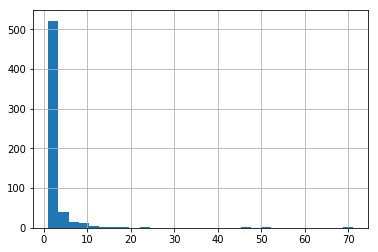

In [26]:
df[df.body.str.contains('fake')].groupby('asin').size()/

In [10]:
df[df.body.str.contains('fake')].head()

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp
5,B000I68EL8,RZH8796W5VGHK,They are totally fake 😡. They felt weird and I finally noticed that the “Made in Germany” is bel...,2,1,1,2018-04-13,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
34,B000I68EL8,RU30SLSPDRB7Z,They were fake- were not comfortable at all. I ended up returning them and buying real ones at D...,0,0,1,2018-06-22,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
59,B000I68EL8,ROV5ARQ3TO9JD,They are fakes not happy,0,0,1,2017-02-04,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
111,B000I68EL8,RDEZQVNM0LGOH,Was skeptical they were fake at first as glue shoes. I think Birkenstocks have gone down in qual...,0,0,4,2017-06-09,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
122,B000I68EL8,RAS5ZP7RWM0TX,"A bit expensive. Thought it was fake at first but they are authentic. Good for a long, casual, a...",0,0,4,2017-08-28,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8


In [8]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

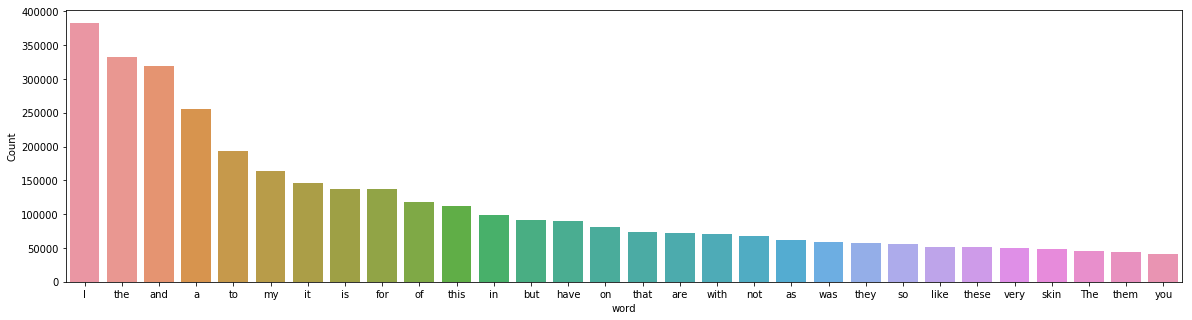

In [9]:
freq_words(df['body'])

Most common words are ‘I’, 'the’, 'and', 'a', ‘to’, so on and so forth. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Before that let’s remove the punctuations and numbers from our text data.

In [10]:
# remove unwanted characters, numbers and symbols
df['body'] = df['body'].str.replace("[^a-zA-Z#]", " ")

In [11]:
#Let’s try to remove the stopwords and short words (<2 letters) from the reviews.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [12]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['body'] = df['body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
body = [remove_stopwords(r.split()) for r in df['body']]

# make entire text lowercase
body = [r.lower() for r in body]

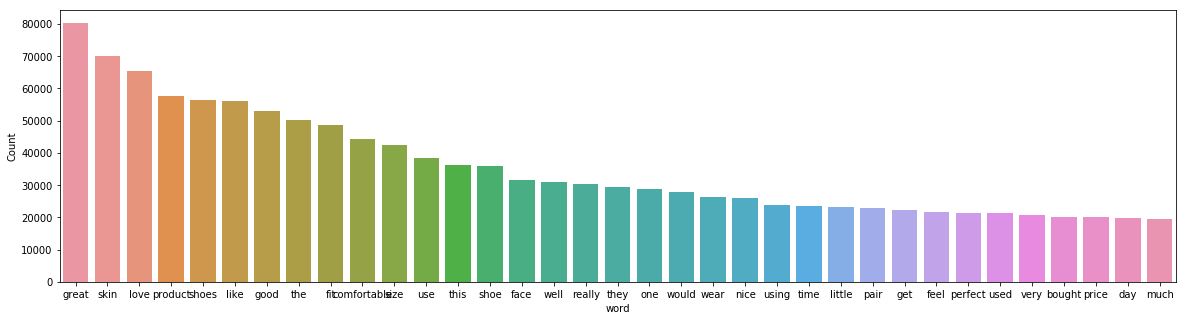

In [13]:
freq_words(body, 35)

In [14]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [15]:
tokenized_body = pd.Series(body).apply(lambda x: x.split())
print(tokenized_body[0])

['feels', 'comfortable', 'wear', 'day']


In [16]:
body_2 = lemmatization(tokenized_body)
print(body_2[0]) # print lemmatized review

['comfortable', 'wear', 'day']


In [17]:
df['comments'] = body_2

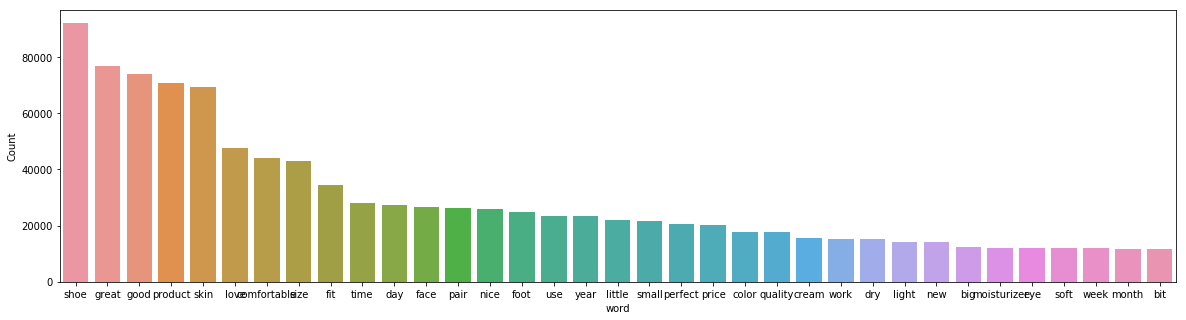

In [18]:
reviews_3 = []
for i in range(len(body_2)):
    reviews_3.append(' '.join(body_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [19]:
df.head()

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit
2,B000I68EL8,RZN7OFKFGQO0N,Birkenstock amazing shoe wish had ten pairs,0,0,5,2017-05-31,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[birkenstock, amazing, shoe, pair]",birkenstock amazing shoe pair
3,B000I68EL8,RZLEB1YTRQQ33,Delivered advertised shoe looks fits expected Leather color seems bit lighter than one seen stor...,0,0,5,2018-06-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[advertised, shoe, expected, leather, color, light, store, satisfactory]",advertised shoe expected leather color light store satisfactory
4,B000I68EL8,RZI71N4TZRCMD,Second pair have had Nothing beats them,0,0,5,2017-02-05,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[second, pair, nothing, beat]",second pair nothing beat


In [20]:
df.brand.fillna('Unknw', inplace = True) #Filling missing values in brand columns

In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [22]:
df['vader_neg'] = 0
df['vader_pos'] = 0
df['vader_neu'] = 0
df['vader_compound'] = 0
for i, q in enumerate(df.reviews.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']

Dealing with missing values"

In [30]:
df.isnull().sum() / len(df) * 100

asin                           0.000000
review_post_id                 0.000000
body                           0.000000
helpful_count                  0.000000
num_images                     0.000000
rating                         0.000000
date_posted                    0.000000
is_verified_purchase           0.000000
is_vine_voice                  0.000000
num_comments                   0.000000
has_video                      0.000000
category                       0.000000
list_price                    96.620104
price_low                     28.611085
price_high                    28.611085
is_add_on                     22.671810
is_prime                      22.671810
is_prime_pantry               22.671810
is_prime_exclusive            22.671810
is_fresh                      22.671810
has_sns                       22.671810
offer_fulfiller               86.244070
offer_merchant                86.244070
lowest_price_new_condition    89.959810
brand                          0.000000


In [31]:
df.head()

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews,vader_neg,vader_pos,vader_neu,vader_compound
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day,0.000,0.623,0.377,0.5106
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit,0.175,0.429,0.397,0.4939
2,B000I68EL8,RZN7OFKFGQO0N,Birkenstock amazing shoe wish had ten pairs,0,0,5,2017-05-31,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[birkenstock, amazing, shoe, pair]",birkenstock amazing shoe pair,0.000,0.559,0.441,0.5859
3,B000I68EL8,RZLEB1YTRQQ33,Delivered advertised shoe looks fits expected Leather color seems bit lighter than one seen stor...,0,0,5,2018-06-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[advertised, shoe, expected, leather, color, light, store, satisfactory]",advertised shoe expected leather color light store satisfactory,0.000,0.263,0.737,0.3612
4,B000I68EL8,RZI71N4TZRCMD,Second pair have had Nothing beats them,0,0,5,2017-02-05,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[second, pair, nothing, beat]",second pair nothing beat,0.000,0.000,1.000,0.0000


In [67]:
my_list = df['reviews']

In [68]:
len(my_list)

358798

In [70]:
my_list[:2]

0                              comfortable wear day
1    package end missing box gift update actual fit
Name: reviews, dtype: object

In [77]:
for each in df['reviews']:
    if "fake" in each or "countefeit" in each or "counterfeiting" in each or "gray market" in each or "not original" in each:
        df['fake_word_detected'] = 1
    else:
        df['fake_word_detected'] = 0


In [78]:
df.head()

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews,vader_neg,vader_pos,vader_neu,vader_compound,fake_word_detected
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day,0.000,0.623,0.377,0.5106,0
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit,0.175,0.429,0.397,0.4939,0
2,B000I68EL8,RZN7OFKFGQO0N,Birkenstock amazing shoe wish had ten pairs,0,0,5,2017-05-31,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[birkenstock, amazing, shoe, pair]",birkenstock amazing shoe pair,0.000,0.559,0.441,0.5859,0
3,B000I68EL8,RZLEB1YTRQQ33,Delivered advertised shoe looks fits expected Leather color seems bit lighter than one seen stor...,0,0,5,2018-06-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[advertised, shoe, expected, leather, color, light, store, satisfactory]",advertised shoe expected leather color light store satisfactory,0.000,0.263,0.737,0.3612,0
4,B000I68EL8,RZI71N4TZRCMD,Second pair have had Nothing beats them,0,0,5,2017-02-05,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[second, pair, nothing, beat]",second pair nothing beat,0.000,0.000,1.000,0.0000,0


In [85]:
df['fake_word_detected'].value_counts()

0    358798
Name: fake_word_detected, dtype: int64

In [40]:
#creating new dataset with no missing values

data = df[['reviews', 'vader_neg', 'vader_pos', 'vader_neu', 'vader_compound', 'brand', 'category', 'has_video', 'num_comments', 'is_verified_purchase', 'rating', 'num_images', 'helpful_count']]
data.shape

(358798, 13)

In [43]:
#filtering out neutral comments. as we only case about negative and positive comments
data = data[data['vader_compound'] != 0.0000]
print(data.shape)
data.head()

(291673, 13)


,reviews,vader_neg,vader_pos,vader_neu,vader_compound,brand,category,has_video,num_comments,is_verified_purchase,rating,num_images,helpful_count
0,comfortable wear day,0.000,0.623,0.377,0.5106,Birkenstock,Women's Shoes,False,0,True,5,0,0
1,package end missing box gift update actual fit,0.175,0.429,0.397,0.4939,Birkenstock,Women's Shoes,False,0,True,3,1,0
2,birkenstock amazing shoe pair,0.000,0.559,0.441,0.5859,Birkenstock,Women's Shoes,False,0,True,5,0,0
3,advertised shoe expected leather color light store satisfactory,0.000,0.263,0.737,0.3612,Birkenstock,Women's Shoes,False,0,True,5,0,0
5,weird germany logo glue leather infuriating happen,0.505,0.000,0.495,-0.6249,Birkenstock,Women's Shoes,False,0,True,1,1,2


In [44]:
cat_columns = ["brand","category", "has_video", "is_verified_purchase"]
dummy_df = pd.get_dummies(data[cat_columns])
data = pd.concat([data, dummy_df], axis=1)
data = data.drop(cat_columns, axis=1)
data.head()

,reviews,vader_neg,vader_pos,vader_neu,vader_compound,num_comments,rating,num_images,helpful_count,brand_37 Actives,brand_7,brand_A,brand_ABH,brand_AROCCOM,brand_ASICS,brand_AVEDA,brand_Advanced Clinicals,brand_Alexander McQueen,brand_Anastasia,brand_Anastasia Beverly Hills,brand_Apple,brand_Aspen Bay,brand_Aveeno,brand_Aveeno Baby,brand_B&O PLAY by Bang & Olufsen,brand_B.,brand_BALLY,brand_BOLIN,brand_BURBERRY,brand_Babor,brand_Balenciaga,brand_Bare Escentuals,brand_Baxter of California,brand_Beats,brand_Bee Friendly Skincare,brand_Benefit Cosmetics,brand_Birkenstock,brand_Blue Lizard,brand_Bobbi Brown,brand_Borghese,brand_Bose,brand_Bowers & Wilkins,brand_Breitling,brand_Breitling Official,brand_Brickell Men's Products,brand_Bulova,brand_Burt's Bees,brand_Burt's Bees Baby,brand_By Kiehl's Since 1851,brand_CHANEL,brand_CHARLOTTE TILBURY,brand_CHI,brand_COVERGIRL,brand_Calvin,brand_Calvin Klein Cotton Classic Multipack Briefs,brand_Calvin Klein Jeans Women's,brand_Capri Blue,brand_Cartier,brand_CeraVe,brand_Christian Dior,brand_Citizen,brand_Clarisonic,brand_Clinique,brand_Coach,brand_Cole,brand_Cole Haan Signature,brand_Colourpop,brand_Control Corrective,brand_Converse,brand_Diane von Furstenberg,brand_Diesel,brand_Dior,brand_Dolce & Gabbana,brand_Dove,brand_Dr. Squatch,brand_ELEMIS,brand_ETEREAUTY,brand_Elchim,brand_Emporio,brand_Estee Lauder,brand_Every Man Jack,brand_FERRARI,brand_Fendi,brand_Ferrari,brand_Fossil,brand_GIORGIO ARMANI,brand_GUESS Factory,brand_Garnier,brand_Garnier Skin,brand_Got2b,brand_Gucci,brand_HP,brand_HUGGIES,brand_Harman Kardon,brand_Hublot,brand_Hugo,brand_ITERY,brand_JBL,brand_JIMMY CHOO,brand_Jack Black,brand_Jan Marini Skin Research,brand_Jaybird,brand_Johnson & Johnson,brand_Johnson's,brand_Johnson's Baby,brand_Julep,brand_Kat Von D,brand_Kate,brand_Kiehl's,brand_Klipsch,brand_L'Occitane,brand_L'Oreal Paris,brand_LANCOME PARIS,brand_LANCï¿½ME,brand_LG,brand_La Roche-Posay,brand_Lacoste,brand_Lancome,brand_Lauren by Ralph Lauren,brand_Lilly,brand_LilyAna Naturals,brand_LilyAna+Naturals,brand_Longchamp,brand_Longchamps,brand_Longines,brand_Louis Vuitton,brand_Lululemon,brand_M-61,brand_M.A.C,brand_MAC,brand_MICHAEL,brand_MICHELE,brand_Majestic Pure,brand_Make Up For Ever,brand_Marc,brand_Marc Jacobs,brand_Marc Jacobs Beauty,brand_Mario Badescu,brand_Marlowe,brand_Maybelline New York,brand_Meaningful Beauty,brand_Mercury + Maia,brand_Michael,brand_Molton Brown,brand_Movado,brand_Mustela,brand_NARS,brand_NIKE,brand_NORDIC CLINICAL,brand_NYX,brand_Natura Siberica,brand_Neutrogena,brand_New,brand_New Balance,brand_Nicefeel,brand_Oars + Alps,brand_Obagi Medical,brand_Olay,brand_Old Spice,brand_Omega,brand_Oral B,brand_PHILIP B,brand_PUMA,brand_Patagonia,brand_Peugeot,brand_Philip B.,brand_Philips Sonicare,brand_Pioneer,brand_Polk Audio,brand_Polo Ralph Lauren,brand_Prada,brand_Proactiv,brand_Pumas,brand_Pure Biology,brand_RALPH LAUREN,brand_Rado,brand_Ralph Lauren Polo,brand_Raymond Weil,brand_Rebecca,brand_Reebok,brand_Resurface by Shani Darden,brand_Revlon,brand_Richland,brand_Roberto Cavalli,brand_Roberto Cavalli by Franck Muller,brand_Rolex,brand_Saint Laurent,brand_Sally Hansen,brand_Salvatore Ferragamo,brand_Samsung,brand_Science Serum,brand_Sennheiser,brand_Shiseido,brand_SkinMedica,brand_Skullcandy,brand_Smashbox,brand_Sonos,brand_Sony,brand_Stella McCartney,brand_StriVectin,brand_Stuart,brand_Su:m 37,brand_Sunlite,brand_Swarovski,brand_Swatch,brand_T3 Micro,brand_TAG Heuer,brand_TOMS,brand_Tarte,brand_The Honest Company,brand_The North Face,brand_Tiffany & Co.,brand_Timberland,brand_Tissot,brand_Tom Ford,brand_Tommy,brand_Too Faced,brand_Tory Burch,brand_Toshiba,brand_TruSkin Naturals,brand_URBAN DECAY,brand_Ultimate Ears,brand_Under,brand_Under Armour,brand_Unknw,brand_Ursa Major,brand_VALENTINO by Mario Valentino,brand_VINCENT LONGO,brand_Vans,brand_Versace,brand_Versace Jeans,brand_Versus by Versace,brand_Vichy,brand_Victorinox,brand_Victorinox Swiss Army,brand_YSL,brand_Yves Saint Laurent

In [46]:
data.shape

(291673, 256)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf = True)

X = vectorizer.fit_transform(data['reviews'])

X.shape # check shape of the document-term matrix

(291673, 1000)

In [60]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

2

In [61]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
great
 
shoe
 
good
 
love
 
comfortable
 
product
 
fit
 
Topic 1: 
love
 
comfortable
 
shoe
 
perfect
 
color
 
pair
 
daughter
 


In [64]:
import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'

In [48]:
x = data.drop('reviews', axis = 1)

In [50]:
x.head()

,vader_neg,vader_pos,vader_neu,vader_compound,num_comments,rating,num_images,helpful_count,brand_37 Actives,brand_7,brand_A,brand_ABH,brand_AROCCOM,brand_ASICS,brand_AVEDA,brand_Advanced Clinicals,brand_Alexander McQueen,brand_Anastasia,brand_Anastasia Beverly Hills,brand_Apple,brand_Aspen Bay,brand_Aveeno,brand_Aveeno Baby,brand_B&O PLAY by Bang & Olufsen,brand_B.,brand_BALLY,brand_BOLIN,brand_BURBERRY,brand_Babor,brand_Balenciaga,brand_Bare Escentuals,brand_Baxter of California,brand_Beats,brand_Bee Friendly Skincare,brand_Benefit Cosmetics,brand_Birkenstock,brand_Blue Lizard,brand_Bobbi Brown,brand_Borghese,brand_Bose,brand_Bowers & Wilkins,brand_Breitling,brand_Breitling Official,brand_Brickell Men's Products,brand_Bulova,brand_Burt's Bees,brand_Burt's Bees Baby,brand_By Kiehl's Since 1851,brand_CHANEL,brand_CHARLOTTE TILBURY,brand_CHI,brand_COVERGIRL,brand_Calvin,brand_Calvin Klein Cotton Classic Multipack Briefs,brand_Calvin Klein Jeans Women's,brand_Capri Blue,brand_Cartier,brand_CeraVe,brand_Christian Dior,brand_Citizen,brand_Clarisonic,brand_Clinique,brand_Coach,brand_Cole,brand_Cole Haan Signature,brand_Colourpop,brand_Control Corrective,brand_Converse,brand_Diane von Furstenberg,brand_Diesel,brand_Dior,brand_Dolce & Gabbana,brand_Dove,brand_Dr. Squatch,brand_ELEMIS,brand_ETEREAUTY,brand_Elchim,brand_Emporio,brand_Estee Lauder,brand_Every Man Jack,brand_FERRARI,brand_Fendi,brand_Ferrari,brand_Fossil,brand_GIORGIO ARMANI,brand_GUESS Factory,brand_Garnier,brand_Garnier Skin,brand_Got2b,brand_Gucci,brand_HP,brand_HUGGIES,brand_Harman Kardon,brand_Hublot,brand_Hugo,brand_ITERY,brand_JBL,brand_JIMMY CHOO,brand_Jack Black,brand_Jan Marini Skin Research,brand_Jaybird,brand_Johnson & Johnson,brand_Johnson's,brand_Johnson's Baby,brand_Julep,brand_Kat Von D,brand_Kate,brand_Kiehl's,brand_Klipsch,brand_L'Occitane,brand_L'Oreal Paris,brand_LANCOME PARIS,brand_LANCï¿½ME,brand_LG,brand_La Roche-Posay,brand_Lacoste,brand_Lancome,brand_Lauren by Ralph Lauren,brand_Lilly,brand_LilyAna Naturals,brand_LilyAna+Naturals,brand_Longchamp,brand_Longchamps,brand_Longines,brand_Louis Vuitton,brand_Lululemon,brand_M-61,brand_M.A.C,brand_MAC,brand_MICHAEL,brand_MICHELE,brand_Majestic Pure,brand_Make Up For Ever,brand_Marc,brand_Marc Jacobs,brand_Marc Jacobs Beauty,brand_Mario Badescu,brand_Marlowe,brand_Maybelline New York,brand_Meaningful Beauty,brand_Mercury + Maia,brand_Michael,brand_Molton Brown,brand_Movado,brand_Mustela,brand_NARS,brand_NIKE,brand_NORDIC CLINICAL,brand_NYX,brand_Natura Siberica,brand_Neutrogena,brand_New,brand_New Balance,brand_Nicefeel,brand_Oars + Alps,brand_Obagi Medical,brand_Olay,brand_Old Spice,brand_Omega,brand_Oral B,brand_PHILIP B,brand_PUMA,brand_Patagonia,brand_Peugeot,brand_Philip B.,brand_Philips Sonicare,brand_Pioneer,brand_Polk Audio,brand_Polo Ralph Lauren,brand_Prada,brand_Proactiv,brand_Pumas,brand_Pure Biology,brand_RALPH LAUREN,brand_Rado,brand_Ralph Lauren Polo,brand_Raymond Weil,brand_Rebecca,brand_Reebok,brand_Resurface by Shani Darden,brand_Revlon,brand_Richland,brand_Roberto Cavalli,brand_Roberto Cavalli by Franck Muller,brand_Rolex,brand_Saint Laurent,brand_Sally Hansen,brand_Salvatore Ferragamo,brand_Samsung,brand_Science Serum,brand_Sennheiser,brand_Shiseido,brand_SkinMedica,brand_Skullcandy,brand_Smashbox,brand_Sonos,brand_Sony,brand_Stella McCartney,brand_StriVectin,brand_Stuart,brand_Su:m 37,brand_Sunlite,brand_Swarovski,brand_Swatch,brand_T3 Micro,brand_TAG Heuer,brand_TOMS,brand_Tarte,brand_The Honest Company,brand_The North Face,brand_Tiffany & Co.,brand_Timberland,brand_Tissot,brand_Tom Ford,brand_Tommy,brand_Too Faced,brand_Tory Burch,brand_Toshiba,brand_TruSkin Naturals,brand_URBAN DECAY,brand_Ultimate Ears,brand_Under,brand_Under Armour,brand_Unknw,brand_Ursa Major,brand_VALENTINO by Mario Valentino,brand_VINCENT LONGO,brand_Vans,brand_Versace,brand_Versace Jeans,brand_Versus by Versace,brand_Vichy,brand_Victorinox,brand_Victorinox Swiss Army,brand_YSL,brand_Yves Saint Laurent,brand_a

In [51]:
# Import PCA
from sklearn.decomposition import PCA
# Create a PCA model with 2 components: pca
pca = PCA(n_components=2)
# Transform the scaled samples: pca_features
pca_features = pca.fit_transform(x)
# Print the shape of pca_features
print(pca_features.shape)

(291673, 2)


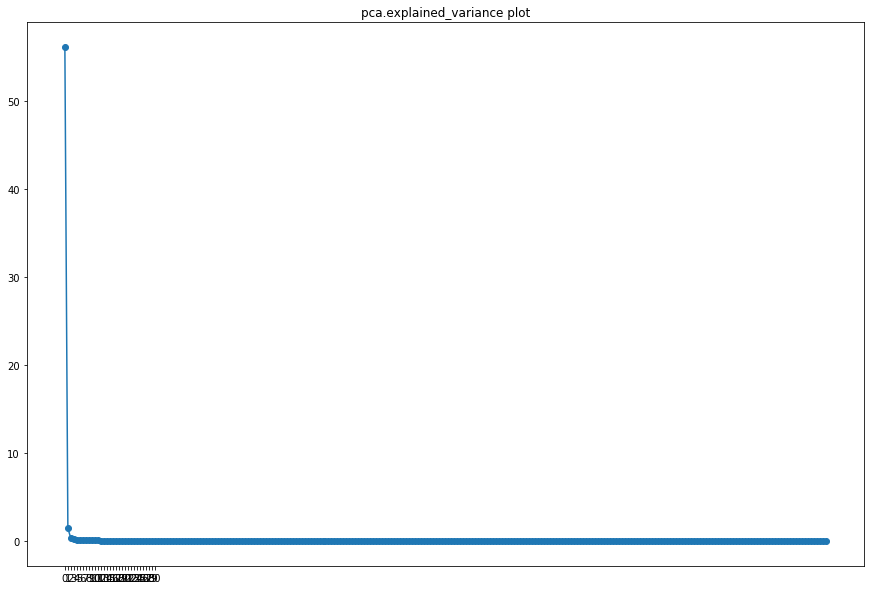

In [52]:

#your turn
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)

plt.figure(figsize= (15,10))
plt.plot(pca.explained_variance_,"o-")
plt.title('pca.explained_variance plot')
plt.xticks(np.arange(0,31))
plt.show()


   cluster_id         x         y
0           0 -0.720429  0.656459
1           0 -0.696056 -1.350151
2           0 -0.720093  0.656913
3           0 -0.718157  0.564159
4           0  1.324867 -3.535422


/Users/lucky/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


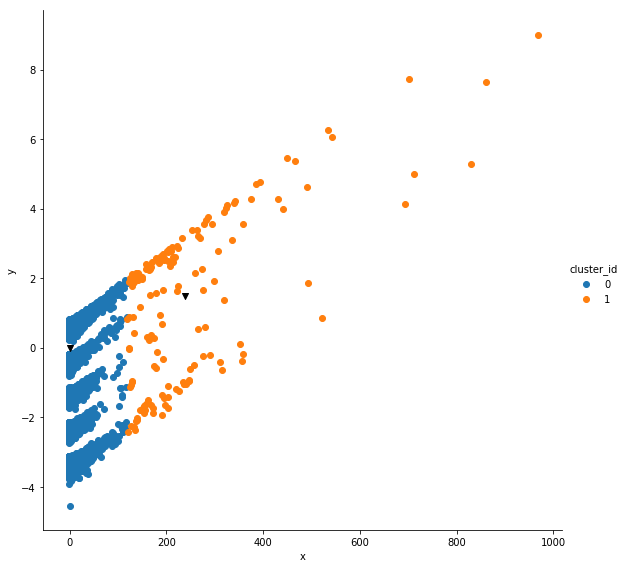

In [55]:
#Create a data frame with the following fields:
#customer name, cluster id the customer belongs to, the two PCA components (label them `x` and `y`)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#get labels for rows in pca_features
kmeans=KMeans(n_clusters=2)
labels=kmeans.fit_predict(x)

newdf2=pd.DataFrame({'cluster_id':labels,'x':pca_features[:,0],'y':pca_features[:,1]})
newdf2=newdf2.reset_index(drop=True)
print(newdf2.head())


#Plot a scatterplot of the `x` vs `y` columns, and color-code points differently based on cluster ID
fg=sns.FacetGrid(data=newdf2, hue='cluster_id', hue_order=[0,1],size=8)
fg.map(plt.scatter, 'x', 'y').add_legend()
cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='v',c='black')
plt.show()

In [49]:
df.sort_values('vader_neg', ascending=False, inplace=True)

In [64]:
df[df['vader_neg'] > .50].isnull().sum()

asin                             0
review_post_id                   0
body                             0
helpful_count                    0
num_images                       0
rating                           0
date_posted                      0
is_verified_purchase             0
is_vine_voice                    0
num_comments                     0
has_video                        0
category                         0
list_price                    5349
price_low                     1736
price_high                    1736
is_add_on                     1160
is_prime                      1160
is_prime_pantry               1160
is_prime_exclusive            1160
is_fresh                      1160
has_sns                       1160
offer_fulfiller               4691
offer_merchant                4691
lowest_price_new_condition    4837
brand                            0
num_reviews                     26
num_images_pdp                   0
comments                         0
reviews             

In [66]:
df[df['vader_neg'] < .50].isnull().sum()

asin                               0
review_post_id                     0
body                               0
helpful_count                      0
num_images                         0
rating                             0
date_posted                        0
is_verified_purchase               0
is_vine_voice                      0
num_comments                       0
has_video                          0
category                           0
list_price                    341226
price_low                     100884
price_high                    100884
is_add_on                      80162
is_prime                       80162
is_prime_pantry                80162
is_prime_exclusive             80162
is_fresh                       80162
has_sns                        80162
offer_fulfiller               304675
offer_merchant                304675
lowest_price_new_condition    317853
brand                              0
num_reviews                     2014
num_images_pdp                     0
c